# Difftest Results

Connect to results database:

In [7]:
import db
from db import *

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

In [8]:
import pandas as pd

session = db.make_session()

TABLE_NAMES = ["CLSmith", "CLSmith w. cldrive", "GitHub", "CLgen"]
TABLES = [CLSmithResult, cldriveCLSmithResult, GitHubResult, CLgenResult]

data = [
    ("#. Programs", [session.query(t.program_id).group_by(t.program_id).count() for t in TABLES]),
    ("#. Testbeds", [session.query(t.testbed_id).group_by(t.testbed_id).count() for t in TABLES]),
    ("#. Params", [session.query(t.params_id).group_by(t.params_id).count() for t in TABLES]),
    ("#. Results", [session.query(t).count() for t in TABLES])
]
i, d = zip(*data)
overview = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
overview

,CLSmith,CLSmith w. cldrive,GitHub,CLgen
#. Programs,10001,10001,9238,1000
#. Testbeds,3,3,3,4
#. Params,4,4,4,4
#. Results,119753,75230,84556,12098


# Experimental Setup

### TestBeds

A testbed is a combination of host platform and OpenCL device.

In [9]:
import sqlalchemy as sql

DEVICES = {  # shorthand device names
    "GeForce GTX 1080": "NVIDIA GTX 1080",
    "Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz": "Intel E5-2620",
    "Olcgrind Simulator": "Oclgrind",
    "pthread-Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz": "Intel E5-2620 (pocl)",
}

DRIVERS = {
    "Oclgrind 16.10": "16.10"
}

q = session.query(Testbed).order_by(sql.func.field(Testbed.devtype, 'GPU', 'CPU', 'Emulator'))

data = []
for testbed in q:
    data.append(
        (testbed.id, [
            testbed.host, DEVICES.get(testbed.device, testbed.device),
            DRIVERS.get(testbed.driver, testbed.driver), testbed.opencl, testbed.devtype] +
         [session.query(t.testbed).filter(t.testbed == testbed).count() for t in TABLES]))
i, d = zip(*data)
testbeds = pd.DataFrame(list(d), index=i, columns=["Operating System", "Device", "Driver", "OpenCL", "Device type"] + [f"#. {t}" for t in TABLE_NAMES])
testbeds

,Operating System,Device,Driver,OpenCL,Device type,#. CLSmith,#. CLSmith w. cldrive,#. GitHub,#. CLgen
3,Ubuntu 16.04 64bit,NVIDIA GTX 1080,375.39,1.2,GPU,160016,138772,189788,16000
9,Ubuntu 16.04 64bit,Intel E5-2620,1.2.0.25,2.0,CPU,160016,160016,147808,16000
12,Ubuntu 16.04 64bit,Intel E5-2620 (pocl),0.14,2.0,CPU,0,0,0,392
11,Ubuntu 16.04 64bit,Oclgrind Simulator,16.10,1.2,Emulator,158980,2132,628,16000


In [10]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
import os
data = []
for testbed in session.query(Testbed):
    data.append([
        testbed.platform, testbed.device, DRIVERS.get(testbed.driver, testbed.driver),
        testbed.opencl, testbed.host, testbed.devtype])
table = pd.DataFrame(data, index=range(1, len(data)+1), columns=[
    "Platform", "Device", "Driver", "OpenCL", "Operating system", "Device type"])
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    table.to_latex(buf=outfile)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
table

Current branch master is up to date.
[master 4c96ad1] auto: build/tab/platforms.tex
 1 file changed, 10 insertions(+), 9 deletions(-)
 rewrite build/tab/platforms.tex (87%)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 559 bytes | 0 bytes/s, done.
Total 5 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   8e1bbb6..4c96ad1  master -> master


,Platform,Device,Driver,OpenCL,Operating system,Device type
1,NVIDIA CUDA,GeForce GTX 1080,375.39,1.2,Ubuntu 16.04 64bit,GPU
2,Intel(R) OpenCL,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,1.2.0.25,2.0,Ubuntu 16.04 64bit,CPU
3,Oclgrind,Oclgrind Simulator,16.10,1.2,Ubuntu 16.04 64bit,Emulator
4,Portable Computing Language,pthread-Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,0.14,2.0,Ubuntu 16.04 64bit,CPU


## Runtime Parameters

### cl_launcher

In [11]:
q = session.query(cl_launcherParams).order_by(
        cl_launcherParams.gsize_x, cl_launcherParams.gsize_y, cl_launcherParams.gsize_z,
        cl_launcherParams.lsize_x, cl_launcherParams.lsize_y, cl_launcherParams.lsize_z,
        cl_launcherParams.optimizations)

data = []
for param in q:
    nresult_param = session.query(CLSmithResult).filter(CLSmithResult.params == param).count()
    data.append((
        param.id, [param.gsize, param.lsize, param.optimizations_on_off, nresult_param]))
i, d = zip(*data)

cl_launcher_params = pd.DataFrame(list(d), index=i, columns=[
    "Global size", "Local size", "Optimizations", "#. CLSmith"])
cl_launcher_params

,Global size,Local size,Optimizations,#. CLSmith
4,"(1, 1, 1)","(1, 1, 1)",off,30003
3,"(1, 1, 1)","(1, 1, 1)",on,30003
2,"(128, 16, 1)","(32, 1, 1)",off,29744
1,"(128, 16, 1)","(32, 1, 1)",on,30003


### cldrive

In [12]:
CLDRIVE_TABLE_NAMES = ["CLSmith w. cldrive", "GitHub", "CLgen"]
CLDRIVE_TABLES = [cldriveCLSmithResult, GitHubResult, CLgenResult]

q = session.query(cldriveParams).order_by(
        cldriveParams.size,
        cldriveParams.gsize_x, cldriveParams.gsize_y, cldriveParams.gsize_z,
        cldriveParams.lsize_x, cldriveParams.lsize_y, cldriveParams.lsize_z,
        cldriveParams.generator, cldriveParams.scalar_val, cldriveParams.optimizations)

data = []
for param in q:
    data.append((
        param.id,
        [param.size, param.generator, param.scalar_val, param.gsize,
         param.lsize, param.optimizations_on_off] + [
            session.query(t).filter(t.params == param).count()
            for t in CLDRIVE_TABLES
        ]))
i, d = zip(*data)

cldrive_params = pd.DataFrame(list(d), index=i, columns=[
    "Size", "Generator", "Scalar Val", "Global size", "Local size",
    "Optimizations"] + [f"#. {t}" for t in CLDRIVE_TABLE_NAMES])
cldrive_params

,Size,Generator,Scalar Val,Global size,Local size,Optimizations,#. CLSmith w. cldrive,#. GitHub,#. CLgen
11,256,arange,None,"(1, 1, 1)","(1, 1, 1)",off,20002,18530,3000
10,256,arange,None,"(1, 1, 1)","(1, 1, 1)",on,20535,18530,3098
12,4096,arange,None,"(128, 16, 1)","(32, 1, 1)",off,14691,26538,3000
9,4096,arange,None,"(128, 16, 1)","(32, 1, 1)",on,20002,20958,3000


In [13]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
data = []
for param in q:
    data.append([param.size, param.gsize, param.lsize, param.optimizations_on_off])
table = pd.DataFrame(data, index=range(1, len(data)+1), columns=[
    "Dataset Size", "Global size", "Workgroup size", "OpenCL Optimizations"])
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/cldrive-params.tex"), "w") as outfile:
    table.to_latex(buf=outfile)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/cldrive-params.tex" && git push
table

Current branch master is up to date.
On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working directory clean


,Dataset Size,Global size,Workgroup size,OpenCL Optimizations
1,256,"(1, 1, 1)","(1, 1, 1)",off
2,256,"(1, 1, 1)","(1, 1, 1)",on
3,4096,"(128, 16, 1)","(32, 1, 1)",off
4,4096,"(128, 16, 1)","(32, 1, 1)",on


# Experimental Results

## Runtimes

Excluding runs which terminated in non-zero status:

In [14]:
import numpy as np

runtimes = [np.array(session.query(table.runtime).filter(table.status == 0).all()) for table in TABLES]
data = [
    ("Min", [r.min() for r in runtimes]),
    ("Median", [np.median(r) for r in runtimes]),
    ("Mean", [r.mean() for r in runtimes]),
    ("Max", [r.max() for r in runtimes])
]
i, d = zip(*data)
runtimes = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
runtimes

,CLSmith,CLSmith w. cldrive,GitHub,CLgen
Min,0.026003,2.279470,2.346580,2.096040
Median,1.224455,3.837550,3.769885,2.475870
Mean,1.913065,4.278828,3.653087,3.607966
Max,58.667400,47.763300,55.092600,46.140600


## Outcomes & Classifications

**Pandas tables of outcomes**

In [15]:
outcomes = {}

r = []
for testbed in session.query(Testbed).all():
    nresult = session.query(CLSmithResult).filter(CLSmithResult.testbed == testbed).count()

    q = session.query(CLSmithResult.outcome, sql.func.count(CLSmithResult.outcome)).filter(
        CLSmithResult.testbed == testbed).group_by(CLSmithResult.outcome).order_by(sql.desc(sql.func.count(CLSmithResult.outcome)))

    for outcome, count in q.all():
        ratio = (count / nresult) * 100
        r.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))
outcomes["CLSmith"] = pd.DataFrame(r, columns=["Device", "Outcome", "Count", "% of Total Results"])
        
for name, table in zip(CLDRIVE_TABLE_NAMES, CLDRIVE_TABLES):
    r = []
    for testbed in session.query(Testbed).all():
        nresult = session.query(table).filter(table.testbed == testbed).count()

        q = session.query(table.outcome, sql.func.count(table.outcome)).filter(
            table.testbed == testbed).group_by(table.outcome).order_by(
                sql.desc(sql.func.count(table.outcome)))

        for outcome, count in q.all():
            ratio = (count / nresult) * 100
            r.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))
    outcomes[name] = pd.DataFrame(r, columns=["Device", "Outcome", "Count", "% of Total Results"])

print("done.")

done.


**Pandas tables of classifications**

In [16]:
classifications = {}

classificationsSort = [
    'Invalid testcase',
    'Build failure',
    'Runtime crash',
    'Wrong code',
    'Okay'
]

def escape(val):
    if val is None:
        return val
    else:
        return str(classificationsSort.index(val)) + ". " + val

r = []
for testbed in session.query(Testbed).all():
    nresult = session.query(CLSmithResult).filter(CLSmithResult.testbed == testbed).count()

    q = session.query(CLSmithResult.classification, sql.func.count(CLSmithResult.classification)).filter(
        CLSmithResult.testbed == testbed).group_by(CLSmithResult.classification).order_by(
            sql.desc(sql.func.count(CLSmithResult.classification)))

    for val, count in q.all():
        ratio = (count / nresult) * 100
        r.append((DEVICES.get(testbed.device, testbed.device), escape(val), count, ratio))
classifications["CLSmith"] = pd.DataFrame(r, columns=["Device", "Classification", "Count", "% of Total Results"])
        
for name, table in zip(CLDRIVE_TABLE_NAMES, CLDRIVE_TABLES):
    r = []
    for testbed in session.query(Testbed).all():
        nresult = session.query(table).filter(table.testbed == testbed).count()

        q = session.query(table.classification, sql.func.count(table.classification)).filter(
            table.testbed == testbed).group_by(table.classification).order_by(
                sql.desc(sql.func.count(table.classification)))

        for val, count in q.all():
            ratio = (count / nresult) * 100
            r.append((DEVICES.get(testbed.device, testbed.device), escape(val), count, ratio))
    classifications[name] = pd.DataFrame(r, columns=["Device", "Classification", "Count", "% of Total Results"])

print("done.")

done.


## Experimental Results

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from labm8 import viz
%matplotlib inline

def plot_outcomes(table, name, dictname=outcomes, key='Outcome'):
    ax = dictname[name].pivot('Device', key)['Count'].plot(
        kind='bar', stacked=True, colormap="Reds_r", sort_columns=True)

    nprog = session.query(table.program_id).group_by(table.program_id).count()
    nparam = session.query(table.params_id).group_by(table.params_id).count()
    plt.title(f"{nprog} {name} x {nparam} parameters")
    plt.ylabel("Results")
    plt.xlabel("")

    plt.ylim(0, nprog * nparam)

    # reverse legend order (because plot stacks from bottom to top, and legend goes from top to bottom)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))

    viz.finalise(figsize=(3.5, 8))

### CLSmith

In [29]:
# outcomes["CLSmith"]
classifications["CLSmith"]

,Device,Classification,Count,% of Total Results
0,NVIDIA GTX 1080,4. Okay,32848,82.111789
1,NVIDIA GTX 1080,0. Invalid testcase,3754,9.384062
2,NVIDIA GTX 1080,1. Build failure,2996,7.489251
3,NVIDIA GTX 1080,2. Runtime crash,385,0.962404
4,NVIDIA GTX 1080,3. Wrong code,21,0.052495
5,Intel E5-2620,4. Okay,28626,71.557844
6,Intel E5-2620,1. Build failure,6685,16.710829
7,Intel E5-2620,0. Invalid testcase,3311,8.276672
8,Intel E5-2620,2. Runtime crash,1382,3.454655
9,Oclgrind Simulator,0. Invalid testcase,12581,31.654296


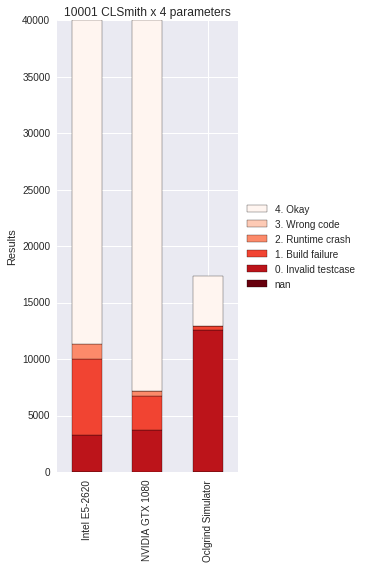

In [30]:
plot_outcomes(CLSmithResult, "CLSmith", dictname=classifications, key='Classification')

### CLSmith w. cldrive

In [31]:
outcomes["CLSmith w. cldrive"]
# classifications["CLSmith w. cldrive"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,Unsupported Program,32899,94.828928
1,NVIDIA GTX 1080,z_Okay,1655,4.770415
2,NVIDIA GTX 1080,No OpenCL kernel,64,0.184475
3,NVIDIA GTX 1080,cldrive Error,56,0.161416
4,NVIDIA GTX 1080,Timeout,12,0.034589
5,NVIDIA GTX 1080,clWaitForEvents(),3,0.008647
6,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,3,0.008647
7,NVIDIA GTX 1080,Segmentation Fault,1,0.002882
8,Intel E5-2620,Unsupported Program,37940,94.840516
9,Intel E5-2620,z_Okay,1812,4.529547


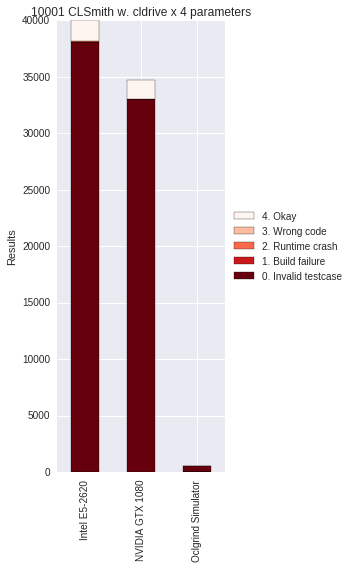

In [32]:
plot_outcomes(cldriveCLSmithResult, "CLSmith w. cldrive", dictname=classifications, key='Classification')

### GitHub

In [33]:
outcomes["GitHub"]
# classifications["GitHub"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,Unsupported Program,17594,37.081375
1,NVIDIA GTX 1080,z_Okay,10019,21.116193
2,NVIDIA GTX 1080,cldrive Error,6816,14.365503
3,NVIDIA GTX 1080,Multiple OpenCL kernels,5330,11.233587
4,NVIDIA GTX 1080,No OpenCL kernel,5018,10.576011
5,NVIDIA GTX 1080,clWaitForEvents(),1502,3.165637
6,NVIDIA GTX 1080,Preprocessing Failed,726,1.530128
7,NVIDIA GTX 1080,INVALID_WORK_GROUP_SIZE,369,0.777710
8,NVIDIA GTX 1080,Timeout,68,0.143318
9,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,3,0.006323


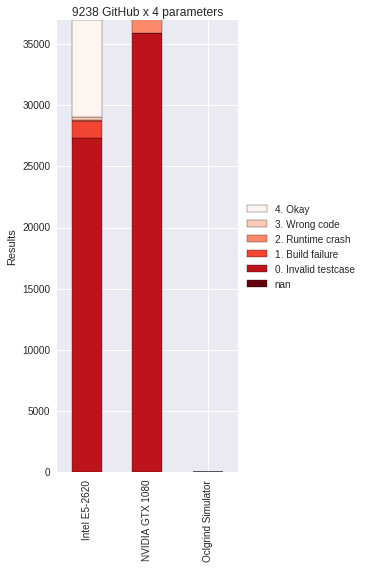

In [34]:
plot_outcomes(GitHubResult, "GitHub", dictname=classifications, key='Classification')

### CLgen

In [35]:
outcomes["CLgen"]
# classifications["CLgen"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,z_Okay,3994,99.85
1,NVIDIA GTX 1080,clWaitForEvents(),6,0.15
2,Intel E5-2620,z_Okay,3984,99.60
3,Intel E5-2620,Segmentation Fault,16,0.40
4,Oclgrind Simulator,z_Okay,1446,36.15
5,Oclgrind Simulator,None,0,0.00
6,Intel E5-2620 (pocl),None,0,0.00


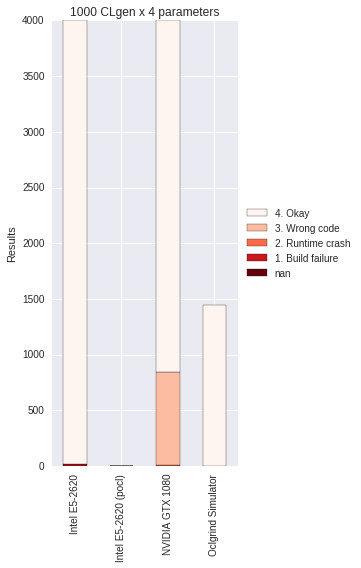

In [36]:
plot_outcomes(CLgenResult, "CLgen", dictname=classifications, key='Classification')